In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.optimize import curve_fit
from scipy.special import factorial
from tqdm import tqdm

In [2]:
plt.rcParams["font.family"] = "serif"

We will implement Euler-Maruyama method and solve some stochastic differential equations.

### Problem 1: Black-Scholes Equation
The Black-Scholes equation is the following:
$$
    dS_t = S_t\mu dt + \sigma S_t dW_t
$$
for the noise term, we are given, $\Delta W_{t_i} = z_i\sqrt{dt}$, where $z_i$ is a random variable with zero mean and unit variance, i.e $z_i\in \mathcal{N}(0,1)$. Thus the approximated solution will be:
$$
    S_{t_i} = S_{t_{i-1}} + S_{t_{i-1}}\mu dt + \sigma S_{t_{i-1}} dW_{t_i}
$$

In [3]:

# solving black-scholes equation
# defining noise function
def w(N, dt):
    """
    Returns array of white noise
    Parameters:
    ==========================
    N:      number of time steps
    dt:     time step

    Returns:
    ==========================
    W:      array of stochastics noise
    """

    W = np.zeros(N) # initlaizing the array
    
    # getting the noise from the Wienner process
    w = np.random.normal(loc=0, scale=1, size=N-1)
    W[1:] = w*np.sqrt(dt) # updating the array

    return W

#defing the approximation of the Black-Scholes equation
def BS(S0,T, N, mu, sigma):
    """
    Returns array of values of the Black-Scholes equation in both approximated and analytical form

    Prarameters:
    ==========================
    S0:     initial price/value of the underlying asset
    T:      time to maturity
    N:      number of time steps
    mu:     expected return of the underlying asset
    sigma:  volatility/variance of the underlying asset

    Returns:
    ==========================
    S           :   Array of values of the Black-Scholes equation in approximated form
    S_analytical:   Array of values of the Black-Scholes equation in analytical form
    t           :   Array of time steps (needed for plotting)
    """

    # defining the time steps
    dt = T/N
    t = np.linspace(0, T, N) #time array

    # Defining the stochastics part of the equation
    W = w(N, dt) # getting the noise from wienner process
    W_T = np.cumsum(W) # time-dependent white noise summed up i.e \eta(t)
    
    # initlaizing the arrays
    S = np.zeros(N)
    S[0] = S0

    # getting the approximated values of the Black-Scholes equation
    for i in range(0, N-1):
        S[i+1] = S[i] + (S[i]*mu*dt) + (S[i]*sigma*W[i+1])
    
    # getting the analytical values of the Black-Scholes equation
    S_analytical = S0*np.exp((mu - 0.5*sigma**2)*t + sigma*W_T)
    
    return S, S_analytical,t
   

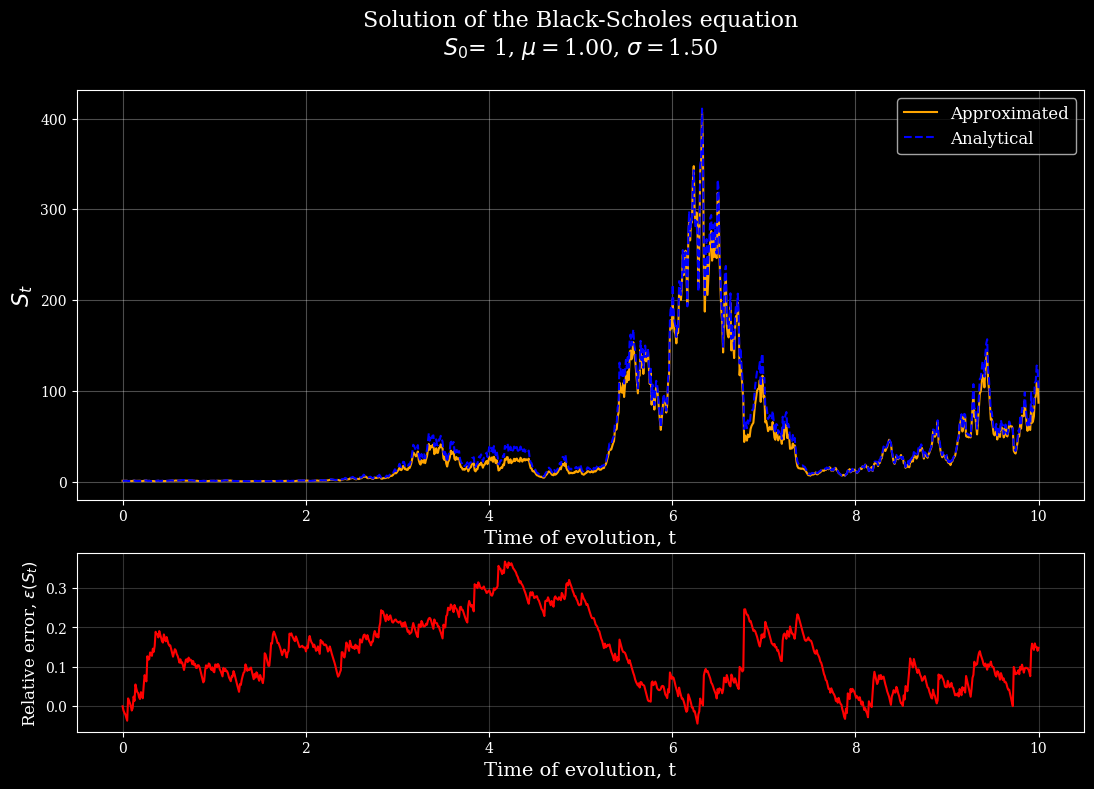

In [30]:
# defining input parameters
S0 = 1
T = 10
N = 1000
mu = 1
sigma = 1.5

# getting solution of the Black-Scholes equation
S, S_analytical,T = BS(S0,T, N, mu, sigma)

fig = plt.figure(figsize=(13,8.5), dpi=100)
grid = plt.GridSpec(3, 1, wspace=0.4, hspace=0.3)

# slecting grids for solution and relative errors
ax1 = fig.add_subplot(grid[0:2, 0])
ax2 = fig.add_subplot(grid[2, 0])

# plotting the approximated and analytical solution
ax1.plot(T, S, lw=1.5,c='orange', label = 'Approximated')
ax1.plot(T, S_analytical, lw=1.5, c='blue', ls='--', label = 'Analytical')
ax1.legend(fontsize=12)
ax1.set_xlabel('Time of evolution, t', fontsize=14)
ax1.set_ylabel('$S_t$', fontsize=16)
ax1.grid(alpha=0.3)
ax1.set_title('Solution of the Black-Scholes equation\n$S_0$= %d, $\\mu=$%2.2f, $\\sigma=$%2.2f\n'%(S0, mu, sigma), fontsize=16)

# plottting the relative error between the approximated and analytical solution
ax2.plot(T, (S_analytical-S)/S_analytical, lw=1.5, c='red')
ax2.set_xlabel('Time of evolution, t', fontsize=14)
ax2.set_ylabel('Relative error, $\epsilon(S_t)$', fontsize=12)
ax2.grid(alpha=0.2)

#plt.savefig('Problem1_a.jpg', dpi=300, bbox_inches='tight')

Realizations: 100%|██████████| 100/100 [00:20<00:00,  4.99it/s]


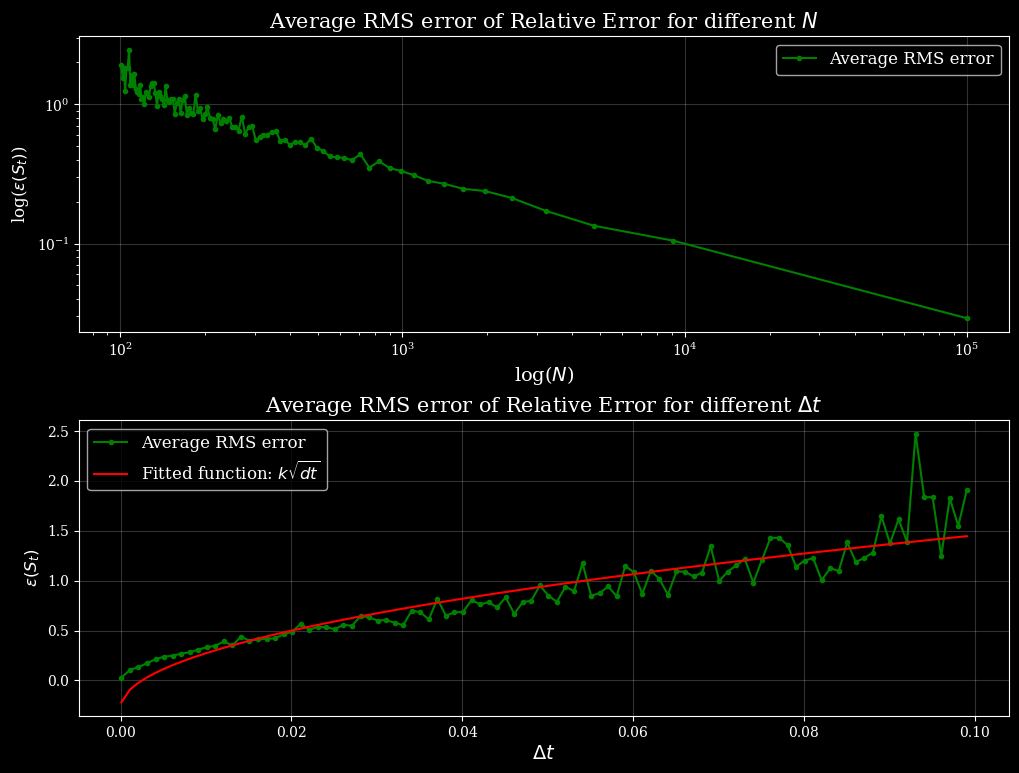

In [31]:
# defining input parameters
S0 = 1
T = 10
N = 1000
mu = 1
sigma = 1.5

# defining square root fitting function
def sqrt_fit(x, a, b):
    return a*np.sqrt(x) + b


# array of time steps
Dt = np.arange(0.0001,0.1,0.001)
N_ar = 10/Dt


#defining a master array to RMS value for many realizations
Master_RMS = []

# number of realizations
N_real = 100

# looping over the number of realizations
for i in tqdm(range(N_real), "Realizations: "):
    # getting RMS error for varrying  time steps
    RMS = np.zeros(len(N_ar))
    for i in range(len(N_ar)):
        S, S_analytical, T_ar = BS(S0,T, int(N_ar[i]), mu, sigma)
        # getting the relative error
        Error = (S_analytical-S)/S_analytical
        RMS[i] = np.sqrt(np.mean(Error**2))
    Master_RMS.append(RMS)

# taking the average of the RMS values
RMS_avg = np.mean(Master_RMS, axis=0)

# fitting RMS error to the square root(dt) function
popt, pcov = curve_fit(sqrt_fit, Dt, RMS_avg)

fig, ax = plt.subplots(2,1, figsize=(12,9), dpi=100, gridspec_kw={'hspace': 0.3})

# plotting the RMS error
ax[0].plot(N_ar, RMS_avg, marker='.', lw=1.5, c='green', label='Average RMS error')
ax[0].loglog()
ax[0].set_xlabel('log($N$)', fontsize=14)
ax[0].set_ylabel('log($\epsilon(S_t)$)', fontsize=12)
ax[0].grid(alpha=0.2)
ax[0].legend(fontsize=12, loc='best')
ax[0].set_title('Average RMS error of Relative Error for different $N$', fontsize=15)



ax[1].plot(10/N_ar, RMS_avg, marker='.', lw=1.5, c='green', label='Average RMS error')
# plotting the fitted function
ax[1].plot(Dt, sqrt_fit(Dt, *popt), lw=1.5, c='red', label='Fitted function: $k\\sqrt{dt}$')
ax[1].set_xlabel('$\Delta t$', fontsize=14)
ax[1].set_ylabel('$\epsilon(S_t)$', fontsize=12)
ax[1].grid(alpha=0.2)
ax[1].legend(fontsize=12, loc='best')
ax[1].set_title('Average RMS error of Relative Error for different $\\Delta t$', fontsize=15);

plt.savefig('Problem1_b.jpg', dpi=300, bbox_inches='tight')

From the above plots, we can clearly see that, the average RMS error increases with time step i.e 
$$
    \epsilon(S_t) \propto \sqrt{dt}
$$
or one can say, it decreases with increasing number of points, N i.e $\epsilon(S_t) \propto (\sqrt{N})^{-1}$

### Problem 2: Birth Death Process
The birth-death process is the following:
$$
    dn = k_1 dt - k_2dt + dW(t)
$$
where the stochastic process is given by,
$$
    \Delta W_i(t) = z_i\sqrt{dt(k_1 + k_2n_{i-1})}
$$

In [32]:
# solving birth-death process
#defing the approximation of the Birth-Death equation
def BD(N0,K1,K2,T, N):
    """
    Returns array of values of the Birth-death equation in approximated  form

    Prarameters:
    ==========================
    N0:     initial number of people
    K1:     initial value of parameter K1
    K2:     initial value of parameter K2
    T:      time to maturity
    N:      number of time steps


    Returns:
    ==========================
    S:              Array of values of the Black-Scholes equation in approximated form
    t           :   Array of time steps (needed for plotting)
    """

    # defining the time steps
    dt = T/N
    t = np.linspace(0, T, N) #time array

    z = np.random.normal(0, 1, N-1) # generating white noise
    
    # initlaizing the arrays
    S = np.zeros(N)
    S[0] = N0

    # getting the approximated values of the Black-Scholes equation
    for i in range(0, N-1):
        S[i+1] = S[i] + (K1*dt) - (K2*S[i]*dt) + (z[i]*np.sqrt(dt*(K1 + K2*S[i])))
    
    # # getting the analytical values of the Black-Scholes equation
    # S_analytical = (K1/K2)*(1-np.exp(-K2*t))
    
    return S,t

# analytical solution of Birth-Death Equation
def BD_analytical(K1, K2, T, N):
    """
    Returns array of values of the Birth-death equation in analytical form

    Prarameters:
    ==========================
    K1:     initial value of parameter K1
    K2:     initial value of parameter K2
    T:      time to maturity
    N:      number of time steps


    Returns:
    ==========================
    S:              Array of values of the Black-Scholes equation in approximated form
    t           :   Array of time steps (needed for plotting)
    """

    # defining the time steps
    dt = T/N
    t = np.linspace(0, T, N) #time array

    # getting the analytical values of the Black-Scholes equation
    S_analytical = (K1/K2)*(1-np.exp(-K2*t))
    
    return S_analytical

Realizations: 100%|██████████| 10000/10000 [01:22<00:00, 120.97it/s]


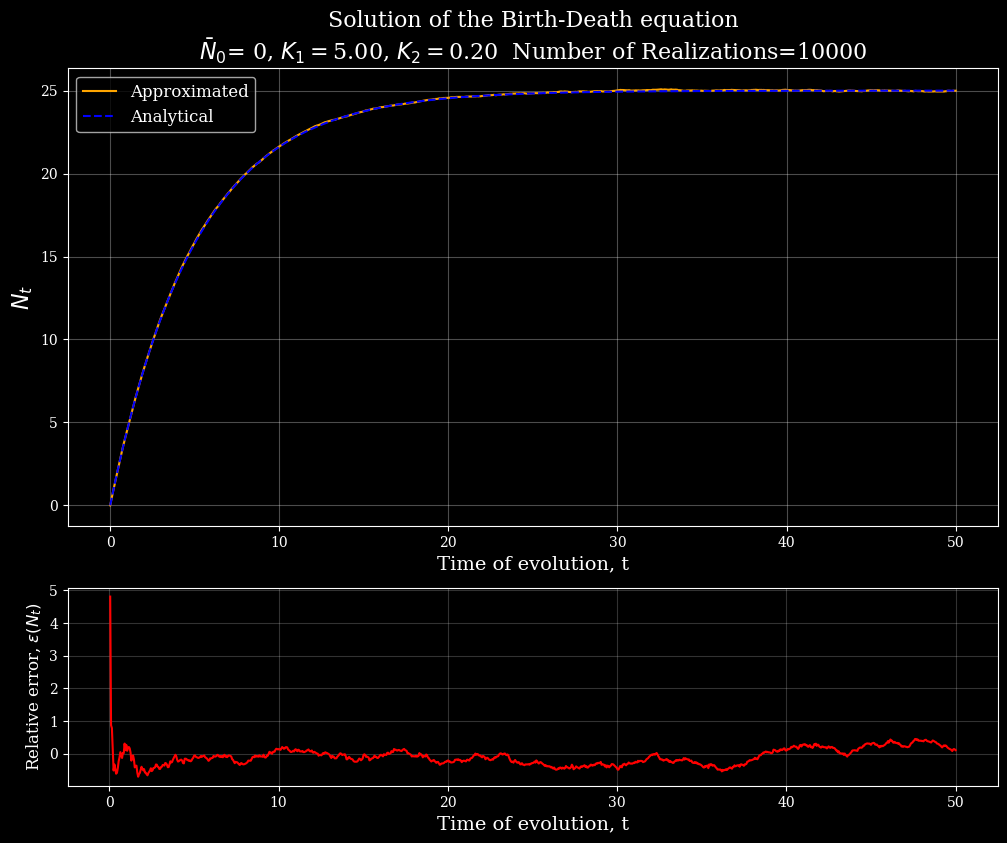

In [33]:
# getting solution for birth-death process
# defining input parameters
K1 = 5
K2 = 0.2
N = 1000
T = 50

# Number of realizations to run
N_real = 10000

# deffining arrary of initial conditions
N0 = np.random.normal(0, 1, N_real)

# defining master array to store the solutions
N_master = []
# defining arrary to store final positions
N_final = []

# looping over the number of realizations
for i in tqdm(range(N_real), "Realizations: "):
    # getting the solution
    N_ar, time_ar = BD(N0[i],K1,K2,T, N)
    N_master.append(N_ar)
    N_final.append(N_ar[-1])
N_analytical = BD_analytical(K1,K2,T, N)

# taking the average of the solutions
N_avg = np.mean(N_master, axis=0)

# plotting the approximated and analytical solution
fig = plt.figure(figsize=(12,9.5), dpi=100)
grid = plt.GridSpec(3, 1, wspace=0.4, hspace=0.31)

# slecting grids for solution and relative errors
ax1 = fig.add_subplot(grid[0:2, 0])
ax2 = fig.add_subplot(grid[2, 0])

# plotting the approximated and analytical solution
ax1.plot(time_ar, N_avg, lw=1.5,c='orange', label = 'Approximated')
ax1.plot(time_ar, N_analytical, lw=1.5, c='blue', ls='--', label = 'Analytical')
ax1.legend(fontsize=12)
ax1.set_xlabel('Time of evolution, t', fontsize=14)
ax1.set_ylabel('$N_t$', fontsize=16)
ax1.grid(alpha=0.3)
ax1.set_title('Solution of the Birth-Death equation\n$\\bar{N}_0$= %d, $K_1=$%2.2f, $K_2=$%2.2f  Number of Realizations=%d'%(0, K1, K2, N_real), fontsize=16)

# plottting the relative error between the approximated and analytical solution
ax2.plot(time_ar[1:], (N_avg[1:]-N_ar[1:])/N_analytical[1:], lw=1.5, c='red');
ax2.set_xlabel('Time of evolution, t', fontsize=14)
ax2.set_ylabel('Relative error, $\epsilon(N_t)$', fontsize=12)
ax2.grid(alpha=0.2)

#plt.savefig('Problem2_a.jpg', dpi=300, bbox_inches='tight')

Text(0.5, 1.0, 'Distribution of Steady State value for Birth-Death Equation')

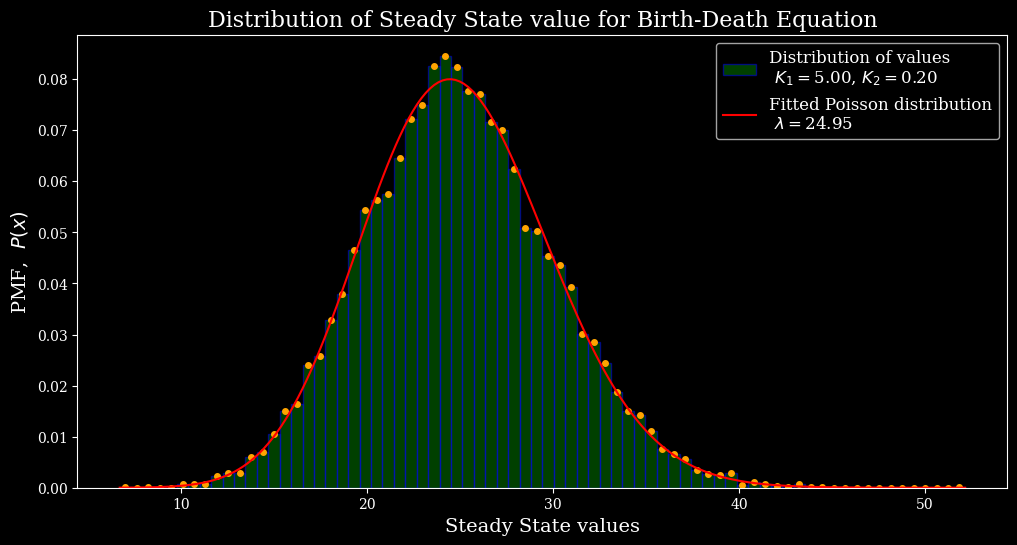

In [304]:
# definging function for poisson fit
def poisson_fit(k,lamb):
    dr = np.ones(len(k))
    for i in range(len(k)):
        if k[i]>0:
            dr[i]=factorial(k[i])
    return np.exp(-lamb)*(lamb**k)/dr

# plotting the distribution of final positions of the solution
fig = plt.figure(figsize=(12,6), dpi=100)
edges = np.histogram_bin_edges(N_final,bins='fd') # bin edges using friedman diaconis rule
# getting midpoints of the bins
bin_centers = (edges[1:] + edges[:-1])/2

vals = plt.hist(N_final, bins=edges, density=True, color='green',edgecolor='blue', alpha=0.5,
                 label='Distribution of values\n $K_1=$%2.2f, $K_2=$%2.2f'%(K1, K2));
plt.plot(bin_centers, vals[0], 'o', ms=4, c='orange')

# fitting the distribution of final positions
popt, pcov = curve_fit(poisson_fit, bin_centers, vals[0],p0=[np.mean(N_final)], maxfev =1000)

# plotting the fitted distribution
x_plot = np.linspace(np.min(N_final), np.max(N_final), 200)
plt.plot(x_plot, poisson_fit(x_plot, *popt), c='red',
         label='Fitted Poisson distribution\n $\\lambda=$%2.2f'%popt[0])

plt.legend(fontsize=12,loc='best')

plt.xlabel('Steady State values', fontsize=14);
plt.ylabel('PMF,  $P(x)$', fontsize=14);

plt.title("Distribution of Steady State value for Birth-Death Equation", fontsize=16)
#plt.savefig('Problem2_b.jpg', bbox_inches='tight', dpi=300)